Loading and preprocessing data...
Identified 4 feature columns and target 'AC_POWER'
Dataframe shape after merge: (1687, 6)
Raw data shapes: X_all=(1687, 4), y_all=(1687, 1)

Processing horizon = 1
Sequence shapes: X_seq=(1663, 24, 4), y_seq=(1663, 1)
Flattened features shape for RF: (1663, 96)
Train samples: 1330, Test samples: 333
Saved model to rf_model_h1.joblib


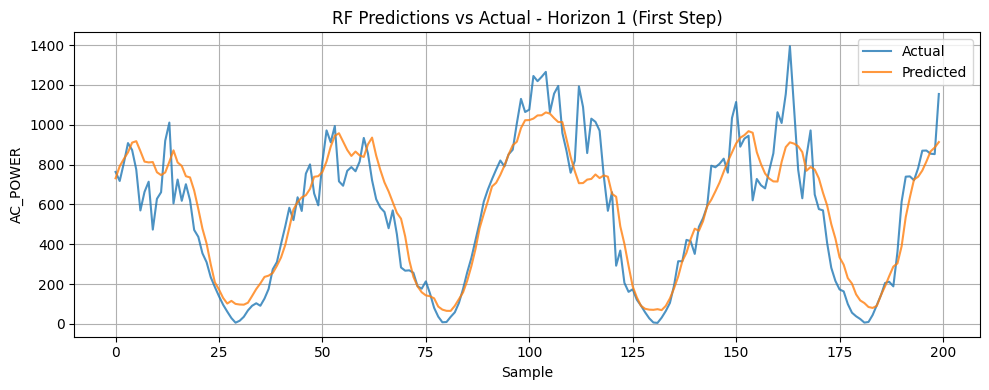

First-step metrics (Horizon=1) -- MAE: 111.32, RMSE: 151.13, R2: 0.8066
Last-step metrics (Horizon=1)  -- MAE: 111.32, RMSE: 151.13, R2: 0.8066
Averaged across steps (Horizon=1) -- MAE_avg: 111.32, RMSE_avg: 151.13, R2_avg: 0.8066

Processing horizon = 5
Sequence shapes: X_seq=(1659, 24, 4), y_seq=(1659, 5)
Flattened features shape for RF: (1659, 96)
Train samples: 1327, Test samples: 332
Saved model to rf_model_h5.joblib


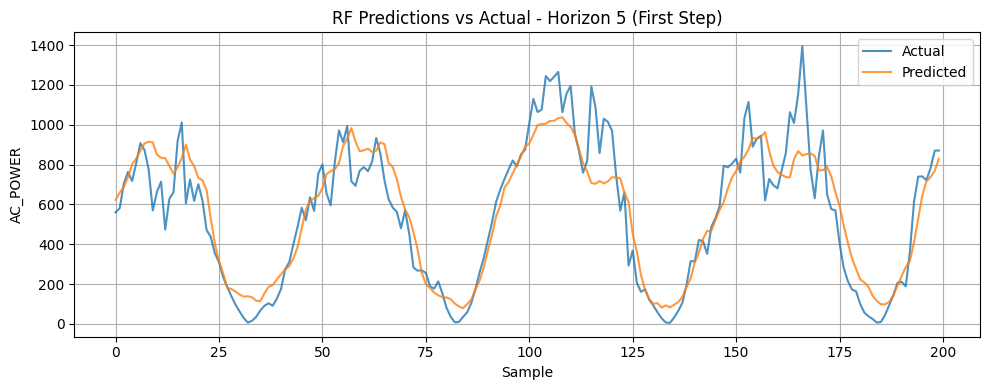

First-step metrics (Horizon=5) -- MAE: 112.12, RMSE: 152.40, R2: 0.7991
Last-step metrics (Horizon=5)  -- MAE: 160.76, RMSE: 203.14, R2: 0.6511
Averaged across steps (Horizon=5) -- MAE_avg: 138.41, RMSE_avg: 180.93, R2_avg: 0.7178

Processing horizon = 24
Sequence shapes: X_seq=(1640, 24, 4), y_seq=(1640, 24)
Flattened features shape for RF: (1640, 96)
Train samples: 1312, Test samples: 328
Saved model to rf_model_h24.joblib


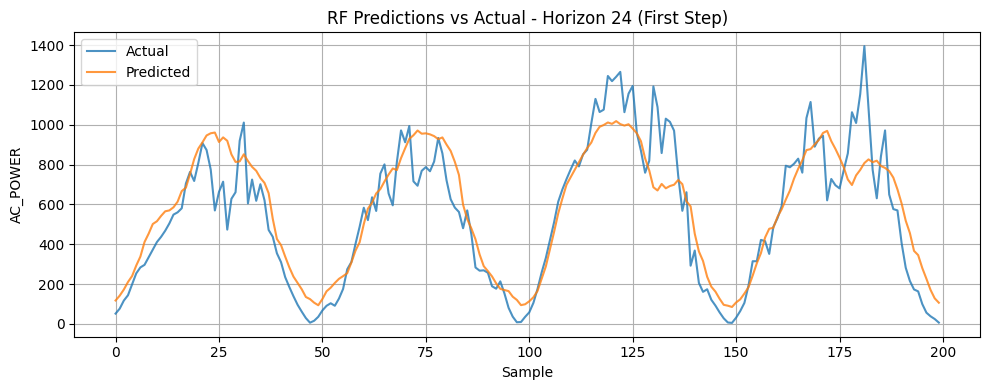

First-step metrics (Horizon=24) -- MAE: 116.72, RMSE: 156.57, R2: 0.7866
Last-step metrics (Horizon=24)  -- MAE: 166.63, RMSE: 206.28, R2: 0.6412
Averaged across steps (Horizon=24) -- MAE_avg: 159.83, RMSE_avg: 198.70, R2_avg: 0.6551

Processing horizon = 72
Sequence shapes: X_seq=(1592, 24, 4), y_seq=(1592, 72)
Flattened features shape for RF: (1592, 96)
Train samples: 1273, Test samples: 319
Saved model to rf_model_h72.joblib


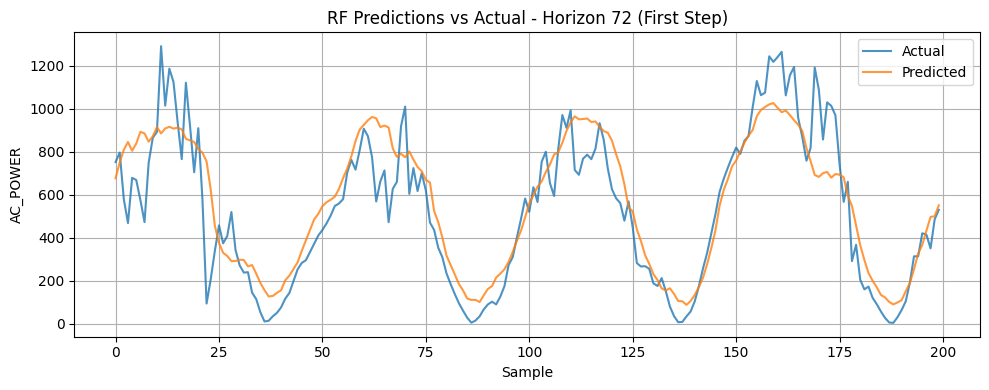

First-step metrics (Horizon=72) -- MAE: 127.55, RMSE: 170.63, R2: 0.7543
Last-step metrics (Horizon=72)  -- MAE: 177.25, RMSE: 210.61, R2: 0.6312
Averaged across steps (Horizon=72) -- MAE_avg: 159.65, RMSE_avg: 194.46, R2_avg: 0.6719

EXPERIMENT SUMMARY (full table):
 Horizon   MAE_last  RMSE_last  R2_last    MAE_avg   RMSE_avg   R2_avg
       1 111.319605 151.133658 0.806565 111.319605 151.133658 0.806565
       5 160.760856 203.142911 0.651107 138.412114 180.930249 0.717788
      24 166.633188 206.283773 0.641192 159.827003 198.696812 0.655112
      72 177.246970 210.605799 0.631177 159.648525 194.456705 0.671936

SUMMARY (using AVERAGED across steps metrics):
 Horizon    MAE_avg   RMSE_avg   R2_avg
       1 111.319605 151.133658 0.806565
       5 138.412114 180.930249 0.717788
      24 159.827003 198.696812 0.655112
      72 159.648525 194.456705 0.671936

Best performing horizon by 'RMSE_avg' (lowest): 1 with RMSE_avg=151.13

Experiment completed successfully!


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

class SolarEnergyForecasterRF:
    def __init__(self,
                 plant_file=r'C:\\Aditya\\College Code\\Big Data Lab\\Solar Energy Analysis and Prediction\\Solar-Energy-Analysis-and-Prediction\\Datasets\\Processed Datasets\\Plant1_filtered.csv',
                 weather_file=r'C:\\Aditya\\College Code\\Big Data Lab\\Solar Energy Analysis and Prediction\\Solar-Energy-Analysis-and-Prediction\\Datasets\\Processed Datasets\\Plant1_Weather_filtered.csv'):
        self.plant_file = plant_file
        self.weather_file = weather_file
        self.results = {}

    def load_and_preprocess_data(self):
        """Load, aggregate and merge plant + weather files. Trees do not need scaling."""
        print("Loading and preprocessing data...")
        plant_df = pd.read_csv(self.plant_file)
        weather_df = pd.read_csv(self.weather_file)

        plant_df['DATE_TIME'] = pd.to_datetime(plant_df['DATE_TIME'])
        weather_df['DATE_TIME'] = pd.to_datetime(weather_df['DATE_TIME'])

        plant_agg = plant_df.groupby('DATE_TIME').agg({'AC_POWER': 'mean'}).reset_index()
        df = pd.merge(weather_df, plant_agg, on='DATE_TIME', how='inner')
        df.set_index('DATE_TIME', inplace=True)

        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        target_col = 'AC_POWER'
        if target_col not in numeric_cols:
            raise ValueError(f"Target column {target_col} not found. Numeric cols: {numeric_cols}")

        feature_cols = [c for c in numeric_cols if c != target_col]
        print(f"Identified {len(feature_cols)} feature columns and target '{target_col}'")
        print(f"Dataframe shape after merge: {df.shape}")

        self.df = df
        self.feature_cols = feature_cols
        self.target_col = target_col
        return df

    def create_sequences(self, X, y, time_steps, horizon):
        """
        Create lag-window sequences.
        X: (T, n_features), y: (T, 1)
        Returns:
            X_seq: (n_samples, time_steps, n_features)
            y_seq: (n_samples, horizon)
        """
        Xs, ys = [], []
        n_total = len(X)
        for i in range(n_total - time_steps - horizon + 1):
            Xs.append(X[i : i + time_steps])
            ys.append(y[i + time_steps : i + time_steps + horizon].flatten())
        return np.array(Xs), np.array(ys)

    def flatten_sequences_for_trees(self, X_seq):
        n_samples, time_steps, n_features = X_seq.shape
        return X_seq.reshape(n_samples, time_steps * n_features)

    def build_and_train_rf(self, X_train, y_train,
                           n_estimators=150, max_depth=8, min_samples_leaf=8,
                           max_features='sqrt', random_state=RANDOM_STATE, n_jobs=-1):
        """Conservative RF to avoid overfitting (produces a mediocre but robust model)."""
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=random_state,
            n_jobs=n_jobs,
            verbose=0
        )
        model.fit(X_train, y_train)
        return model

    def _per_step_metrics(self, y_true, y_pred):
        """
        Compute per-step MAE, RMSE, R2 and return lists and their averages.
        y_true, y_pred: (n_samples, horizon)
        """
        horizon = y_true.shape[1]
        mae_list, rmse_list, r2_list = [], [], []
        for i in range(horizon):
            yt = y_true[:, i]
            yp = y_pred[:, i]
            mae = mean_absolute_error(yt, yp)
            rmse = np.sqrt(mean_squared_error(yt, yp))
            # r2 can be negative; handle constant arrays gracefully (r2_score raises warning but returns)
            r2 = r2_score(yt, yp)
            mae_list.append(mae)
            rmse_list.append(rmse)
            r2_list.append(r2)
        # averages across all steps
        return {
            'mae_per_step': mae_list,
            'rmse_per_step': rmse_list,
            'r2_per_step': r2_list,
            'mae_avg': float(np.mean(mae_list)),
            'rmse_avg': float(np.mean(rmse_list)),
            'r2_avg': float(np.mean(r2_list))
        }

    def evaluate_model(self, model, X_test, y_test):
        """
        Predict and compute metrics. Returns metrics dict that includes:
         - overall flattened metrics, per-step lists, averages, and last-step metrics.
        """
        y_pred = model.predict(X_test)

        # Normalize shapes to 2D: (n_samples, horizon)
        if y_test.ndim == 1:
            y_test = y_test.reshape(-1, 1)
        if y_pred.ndim == 1:
            y_pred = y_pred.reshape(-1, 1)

        if y_test.shape[1] != y_pred.shape[1]:
            raise ValueError(f"Shape mismatch between y_test {y_test.shape} and y_pred {y_pred.shape}")

        # Flatten metrics across all steps (like before)
        y_test_flat = y_test.flatten()
        y_pred_flat = y_pred.flatten()
        mae_all = mean_absolute_error(y_test_flat, y_pred_flat)
        rmse_all = np.sqrt(mean_squared_error(y_test_flat, y_pred_flat))
        r2_all = r2_score(y_test_flat, y_pred_flat)

        per_step = self._per_step_metrics(y_test, y_pred)

        # Last-step metrics:
        last_idx = y_test.shape[1] - 1
        mae_last = per_step['mae_per_step'][last_idx]
        rmse_last = per_step['rmse_per_step'][last_idx]
        r2_last = per_step['r2_per_step'][last_idx]

        metrics = {
            'mae_all_flat': mae_all,
            'rmse_all_flat': rmse_all,
            'r2_all_flat': r2_all,
            'mae_last': mae_last,
            'rmse_last': rmse_last,
            'r2_last': r2_last,
            'mae_avg': per_step['mae_avg'],
            'rmse_avg': per_step['rmse_avg'],
            'r2_avg': per_step['r2_avg'],
            'mae_per_step': per_step['mae_per_step'],
            'rmse_per_step': per_step['rmse_per_step'],
            'r2_per_step': per_step['r2_per_step']
        }
        return metrics, y_pred

    def plot_predictions(self, y_test, y_pred, horizon, metrics, n_plot=200):
        """Plot actual vs predicted for the first forecast step (same as before)."""
        if y_test.ndim == 1:
            y_test = y_test.reshape(-1, 1)
        if y_pred.ndim == 1:
            y_pred = y_pred.reshape(-1, 1)

        n_samples = min(n_plot, len(y_test))
        plt.figure(figsize=(10, 4))
        plt.plot(y_test[:n_samples, 0], label='Actual', alpha=0.8)
        plt.plot(y_pred[:n_samples, 0], label='Predicted', alpha=0.8)
        plt.title(f'RF Predictions vs Actual - Horizon {horizon} (First Step)')
        plt.xlabel('Sample')
        plt.ylabel('AC_POWER')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f"First-step metrics (Horizon={horizon}) -- MAE: {metrics['mae_per_step'][0]:.2f}, RMSE: {metrics['rmse_per_step'][0]:.2f}, R2: {metrics['r2_per_step'][0]:.4f}")
        print(f"Last-step metrics (Horizon={horizon})  -- MAE: {metrics['mae_last']:.2f}, RMSE: {metrics['rmse_last']:.2f}, R2: {metrics['r2_last']:.4f}")
        print(f"Averaged across steps (Horizon={horizon}) -- MAE_avg: {metrics['mae_avg']:.2f}, RMSE_avg: {metrics['rmse_avg']:.2f}, R2_avg: {metrics['r2_avg']:.4f}")

    def run_experiment(self, time_steps=24, horizons=[1,5,24,72], test_frac=0.2, random_state=RANDOM_STATE, summary_agg='avg'):
        """
        Run pipeline and print summary aggregated either by 'last' step or 'avg' across steps.
        summary_agg: 'last' or 'avg' (default 'avg')
        """
        if summary_agg not in ('last', 'avg'):
            raise ValueError("summary_agg must be 'last' or 'avg'")

        df = self.load_and_preprocess_data()

        X_all = df[self.feature_cols].values
        y_all = df[[self.target_col]].values

        print(f"Raw data shapes: X_all={X_all.shape}, y_all={y_all.shape}")

        results = {}

        for horizon in horizons:
            print("\n" + "="*60)
            print(f"Processing horizon = {horizon}")
            print("="*60)

            X_seq, y_seq = self.create_sequences(X_all, y_all, time_steps=time_steps, horizon=horizon)
            print(f"Sequence shapes: X_seq={X_seq.shape}, y_seq={y_seq.shape}")

            X_flat = self.flatten_sequences_for_trees(X_seq)
            print(f"Flattened features shape for RF: {X_flat.shape}")

            split_idx = int(len(X_flat) * (1 - test_frac))
            X_train, X_test = X_flat[:split_idx], X_flat[split_idx:]
            y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

            print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

            model = self.build_and_train_rf(
                X_train, y_train,
                n_estimators=150,
                max_depth=8,
                min_samples_leaf=8,
                max_features='sqrt',
                random_state=random_state
            )

            metrics, y_pred = self.evaluate_model(model, X_test, y_test)

            model_fname = f'rf_model_h{horizon}.joblib'
            joblib.dump(model, model_fname)
            print(f"Saved model to {model_fname}")

            results[horizon] = {
                'model': model,
                'metrics': metrics,
                'y_pred': y_pred,
                'y_test': y_test
            }

            self.plot_predictions(y_test, y_pred, horizon, metrics, n_plot=200)

        self.results = results

        # Build summary table including both last-step and averaged metrics for transparency
        summary_rows = []
        for h, r in results.items():
            m = r['metrics']
            summary_rows.append({
                'Horizon': h,
                'MAE_last': m['mae_last'],
                'RMSE_last': m['rmse_last'],
                'R2_last': m['r2_last'],
                'MAE_avg': m['mae_avg'],
                'RMSE_avg': m['rmse_avg'],
                'R2_avg': m['r2_avg']
            })
        summary_df = pd.DataFrame(summary_rows).sort_values('Horizon').reset_index(drop=True)

        # Print the requested aggregation view
        print("\nEXPERIMENT SUMMARY (full table):")
        print(summary_df.to_string(index=False))

        if summary_agg == 'last':
            print("\nSUMMARY (using LAST step metrics):")
            print(summary_df[['Horizon','MAE_last','RMSE_last','R2_last']].to_string(index=False))
        else:
            print("\nSUMMARY (using AVERAGED across steps metrics):")
            print(summary_df[['Horizon','MAE_avg','RMSE_avg','R2_avg']].to_string(index=False))

        # Also report the best horizon under the chosen aggregation (lowest RMSE)
        key = 'RMSE_last' if summary_agg == 'last' else 'RMSE_avg'
        best_horizon = summary_df.loc[summary_df[key].idxmin(), 'Horizon']
        best_value = summary_df.loc[summary_df[key].idxmin(), key]
        print(f"\nBest performing horizon by '{key}' (lowest): {best_horizon} with {key}={best_value:.2f}")

        return results


if __name__ == "__main__":
    forecaster = SolarEnergyForecasterRF()

    # Change summary_agg to 'last' if you prefer last-step metrics summary.
    results = forecaster.run_experiment(
        time_steps=24,
        horizons=[1, 5, 24, 72],
        test_frac=0.2,
        summary_agg='avg'   # 'avg' or 'last'
    )

    print("\nExperiment completed successfully!")
